# Анализ и предсказание продаж рынка компьютерных игр (python, pandas, проверка гипотез) #


## Описание проекта
**Легенда:**. 

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, *Xbox* или *PlayStation*). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
 
**Задача:**  

Выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats as st


In [2]:
df = pd.read_csv('/datasets/games.csv')

In [4]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


## Предобработка данных ##

### Преобразование данных ###


In [5]:
#приводим к нижнему регистру
df.columns.tolist()
df.columns = df.columns.str.lower()
df.columns
#df.info()
df['genre']= df['genre'].str.lower()
# обработаем строку с информацией о годе выпуска, заменим пропуски на нулевые значения, поменяем тип данных
df['year_of_release'].fillna(0)
df['year_of_release'] = df['year_of_release'].astype('Int64')


### Обработка пропусков ###

Пропуске в year_of_release заменяем на 0.  
Заменим значения в столбце rating, critic_score и user_score на -1, так как заполнение их средним или медианой исказит данные.
Пропуски в year_of_release оставим без изменения. Строки с пропуском в name - удалим  
Заполним пропуски в year_of_release значением 2050.  
  
Пропуски могли появится при обновлении базы данных или при некорректном заполнении базы.

In [6]:
df['year_of_release'] = df['year_of_release'].fillna(2050)
df['user_score'] = df['user_score'].fillna(-1)
df['critic_score'] = df['critic_score'].fillna(-1)
df['rating'] = df['rating'].fillna(-1)
df = df.dropna(subset=['name'])

# проверим, есть ли дубликаты
df.duplicated().sum()

# проверям, что пропусков не осталось
df.isnull().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

### Обработка user_score со значениями 'tbd'  ###
Строка "tbd" встречается в данных за разные годы, ошибка могла возникнуть при обновлении бащы. Восстановить данных невозможно, для дальнейшей работы в базой заменим данные на NaN


In [7]:
#посмотрим сколько даных с такой строкой, посмотрим за какой год эти записи
df['user_score'].unique()
df[df['user_score'] == 'tbd'].count()
df[df['user_score'] == 'tbd']['year_of_release']
# заменим значения на nan
df.loc[df['user_score'] == 'tbd','user_score'] = np.nan

# заменим тип данных, для дальнейших расчетов
df['user_score'] = df['user_score'].astype('float64')

### Добавление столбца - сумма продаж по регионам ###

In [9]:

cols = ['na_sales', 'eu_sales','jp_sales','other_sales']
df['sum_sales'] = df[cols].sum(axis= 1)

## Исследовательский анализ данных ##

- Изучим, сколько игр выпускалось в разные годы и как менялись продажи по платформам. 
- Определим платформы с наибольшими суммарными продажами.
- Выясним, за какой характерный срок появляются новые и исчезают старые платформы?
- Какие платформы лидируют по продажам, растут или падают. 
- Посмотрим, как отзывы пользователей и критиков влияют на продажи внутри одной популярной платформы.
- Изучим на общее распределение игр по жанрам.

### Выпуск игр по годам ###

In [86]:
year_of_release_pivot_table = pd.pivot_table(df, index='year_of_release', values='name', aggfunc='count')

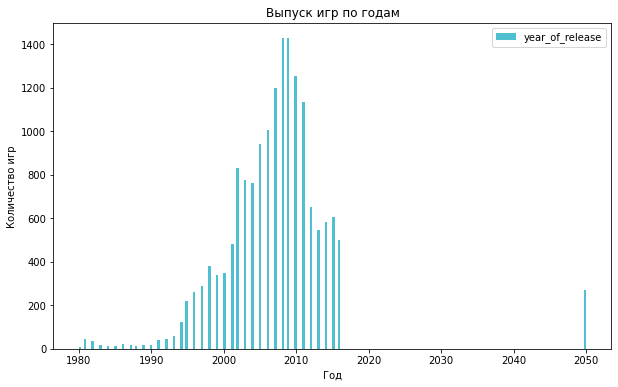

In [88]:
ax = df['year_of_release'].plot(kind='hist', bins=200, figsize=(10, 6), color='#50BFCF')
ax.legend()
ax.set_ylabel('Количество игр')
ax.set_xlabel('Год')
plt.title('Выпуск игр по годам')

plt.show()



В период с 1980 по 1992 выпускается небольшое количество игр. Этот период менее интересен для анализа продаж в будущем. Затем идет стремительный рост индустрии игр, который достигает пика с период 2003-2010 годы.

 ### Как менялись продажи по платформам ### 

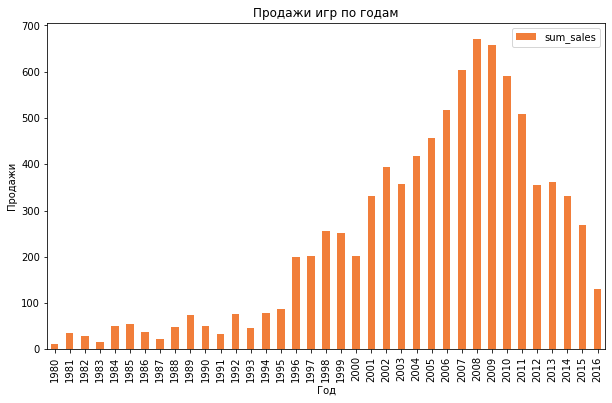

,sum_sales
platform,
PS2,1255.77
X360,971.42
PS3,939.65
Wii,907.51
DS,806.12
PS,730.86
GBA,317.85
PS4,314.14
PSP,294.05


In [89]:
ax = df.query('year_of_release != 2050').groupby('year_of_release').agg({'sum_sales':'sum'}).plot(kind='bar', figsize=(10,6), color='#F17E3A')
ax.set_xlabel('Год')
ax.set_ylabel('Продажи')
plt.title('Продажи игр по годам')

plt.show()

pivot_sales = df.pivot_table(index = 'platform', 
                            values = 'sum_sales',
                            aggfunc = np.sum)
pivot_sales.sort_values('sum_sales',ascending=False).head(10)


In [90]:
best_platform = pivot_sales.sort_values('sum_sales',ascending=False).index[:6]
best_platform


Index(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS'], dtype='object', name='platform')

Рассмотрим платформы с самыми высокими показателями продаж от 700 экз.  
Это платформы: PS2, X360, PS3, Wii, DS, PS
Посмотрим как продавались игры на этих платформах по годам.

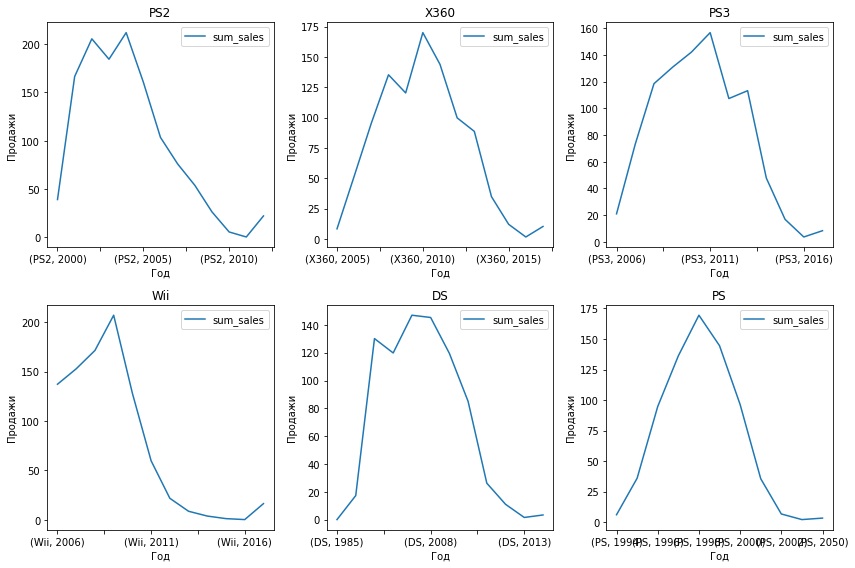

In [97]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 30))

for i, platform in enumerate(best_platform):
    platform_pivot_table = pd.pivot_table(df.query('platform == @platform'),
                                          index=['platform','year_of_release'], 
                                          values='sum_sales',
                                          aggfunc='sum')
    
    row = i // 3
    col = i % 3

    ax = axes[row, col]
    platform_pivot_table.plot(ax=ax, title=platform, figsize=(12, 8))
    ax.set_xlabel('Год')
    ax.set_ylabel('Продажи')

plt.tight_layout()
plt.show()


#### Вывод ####

В среднем платформа популярна и хорошо продается в первые 3-4 года, затем популярность падает. Это связано с выпуском новых платформ и устареванием имеющихся.

###   Определение актуального периода ###


На основании предыдущего анализа, в качестве актуального периода возьмем данные за 4 года, период с 2013 по 2016 год.  
Эти данные помогут сделать прогноз для 2017 года.

In [98]:
#выделим в отдельный датафрейм данные только актуального периода
actual_df = df.query('year_of_release >= 2013')
actual_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2502 entries, 16 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             2502 non-null   object 
 1   platform         2502 non-null   object 
 2   year_of_release  2502 non-null   Int64  
 3   genre            2502 non-null   object 
 4   na_sales         2502 non-null   float64
 5   eu_sales         2502 non-null   float64
 6   jp_sales         2502 non-null   float64
 7   other_sales      2502 non-null   float64
 8   critic_score     2502 non-null   float64
 9   user_score       2346 non-null   float64
 10  rating           2502 non-null   object 
 11  sum_sales        2502 non-null   float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 256.6+ KB


### Прибыльные платформы за 2014-2016 гг ###

In [101]:
#посмотрим распределение продаж по платформам по годам
good_platform_pivot = pd.pivot_table(actual_df.query('year_of_release != 2050'),
                                     index=['platform','year_of_release'], 
                                     values='sum_sales',
                                     aggfunc = 'sum')
good_platform_pivot.head(10)

sum_sales
platform year_of_release           
3DS      2013                 56.57
         2014                 43.76
         2015                 27.78
         2016                 15.14
DS       2013                  1.54
PC       2013                 12.38
         2014                 13.28
         2015                  8.52
         2016                  5.25
PS3      2013                113.25

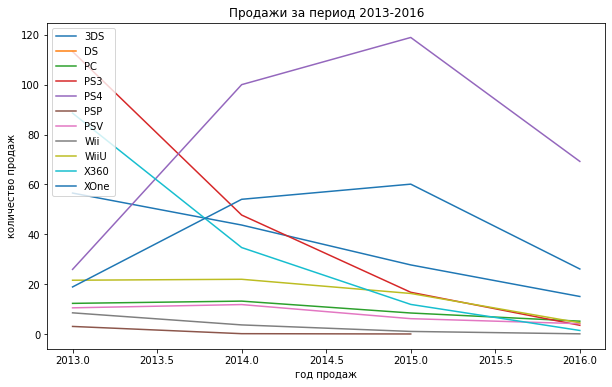

In [102]:
good_platform_pivot.pivot_table(index='year_of_release',
                                columns = 'platform',
                                values = 'sum_sales',
                                aggfunc = 'sum').plot(figsize=(10, 6),
                                                      title='Продажи за период 2013-2016',
                                                      xlabel = 'год продаж',
                                                      ylabel = 'количество продаж')
plt.legend(loc='upper left');


In [103]:
#посмотрим общие продажи по платформам за актуальный период
best_sales_platform = pd.pivot_table(actual_df, index='platform', 
                                     values='sum_sales',
                                     aggfunc = 'sum')
best_sales_platform.sort_values('sum_sales', ascending=False).head(10)

,sum_sales
platform,
PS4,314.14
PS3,189.74
XOne,159.32
X360,146.98
3DS,144.44
WiiU,64.63
PC,43.19
PSV,33.25
Wii,29.99


#### Вывод ####

Получаем 5 платформ с лучшими продажами. Это PS4, PS3, XOne, X360, 3DS

### График продаж по прибыльным платформам ###

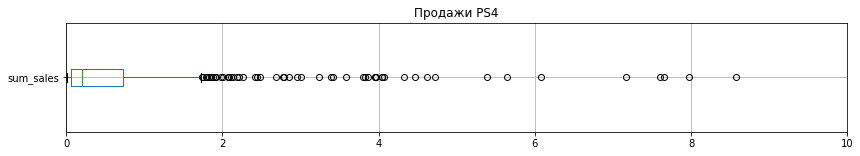

In [104]:
PS4 = actual_df.query('platform =="PS4"')

fig, ax = plt.subplots(figsize = (14,2))
ax = PS4[['sum_sales']].boxplot(vert = False, ax =ax)
ax.set_title('Продажи PS4')
ax.set_xlim(0, 10);
PS4['sum_sales'].describe();

PS4 активно продается 3-4 года, затем продажи снижаются, но в течении 9 лет платформа еще продается, в отличии от иных платформ

count    370.000000
mean       0.512811
std        1.406207
min        0.010000
25%        0.050000
50%        0.155000
75%        0.490000
max       21.050000
Name: sum_sales, dtype: float64

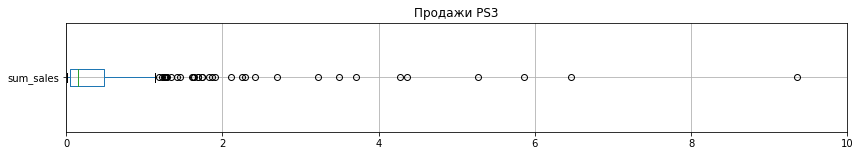

In [105]:
PS3 = actual_df.query('platform =="PS3"')
fig, ax = plt.subplots(figsize = (14,2))
ax = PS3[['sum_sales']].boxplot(vert = False, ax =ax)
ax.set_title('Продажи PS3')
ax.set_xlim(0, 10);
PS3['sum_sales'].describe()


PS3 продается 2-3 года, затем продажи снижаются.

count    247.000000
mean       0.645020
std        1.036139
min        0.010000
25%        0.060000
50%        0.220000
75%        0.685000
max        7.390000
Name: sum_sales, dtype: float64

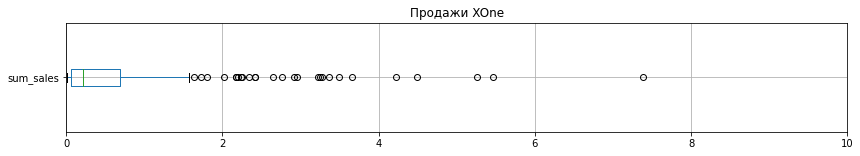

In [106]:
XOne = actual_df.query('platform =="XOne"')
fig, ax = plt.subplots(figsize = (14,2))
ax = XOne[['sum_sales']].boxplot(vert = False, ax =ax)
ax.set_title('Продажи XOne')
ax.set_xlim(0, 10);
XOne['sum_sales'].describe()

XOne активно продается 3 года, затем продажи снижаются, через 5 лет после выпуска практически нет продаж.

count    216.000000
mean       0.680463
std        1.559238
min        0.010000
25%        0.080000
50%        0.245000
75%        0.747500
max       16.270000
Name: sum_sales, dtype: float64

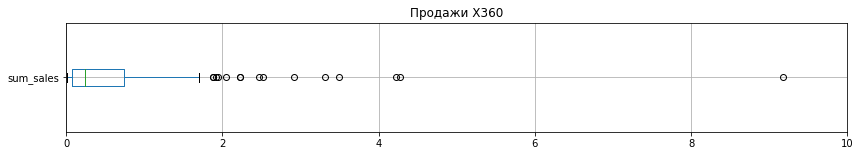

In [107]:
X360 = actual_df.query('platform =="X360"')
fig, ax = plt.subplots(figsize = (14,2))
ax = X360[['sum_sales']].boxplot(vert = False, ax =ax)
ax.set_title('Продажи X360')
ax.set_xlim(0, 10);
X360['sum_sales'].describe()

X360 продается 2-3 года, через 5 лет после выпуска практически нет продаж. Срок жизни этой платформы 4 года

count    311.000000
mean       0.464437
std        1.364530
min        0.010000
25%        0.040000
50%        0.090000
75%        0.280000
max       14.600000
Name: sum_sales, dtype: float64

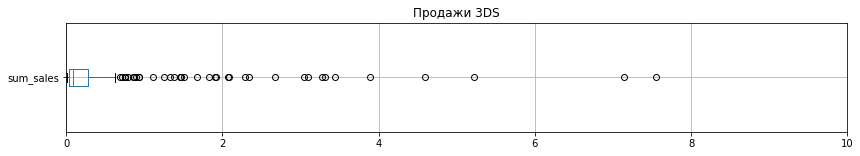

In [108]:
platform_3DS = actual_df.query('platform =="3DS"')
fig, ax = plt.subplots(figsize = (14,2))
ax = platform_3DS[['sum_sales']].boxplot(vert = False, ax =ax)
ax.set_title('Продажи 3DS')
ax.set_xlim(0,10);
platform_3DS['sum_sales'].describe()

3DS хорошо продается в первые 2 года, затем продажи снижаются. Срок жизни этой платформы 4-5 лет.

#### Вывод ####

Платформа хорошо продается 3-4 года, затем идет спад продаж, связанный с появлением на рынке более современных платформ. Платформы PS3 и PS4 продолжают продаваться в течении 10 лет, хотя и продажи снижаются. Это отличает их от конкурентов. Срок "жизни" остальных популярных платформ не превышается 5-6 лет.

### Влияние на продажи популярных платформ отзывов пользователей и критиков ###

 Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. 

In [109]:
actual_df = actual_df.query('critic_score!= -1 & user_score!= -1')

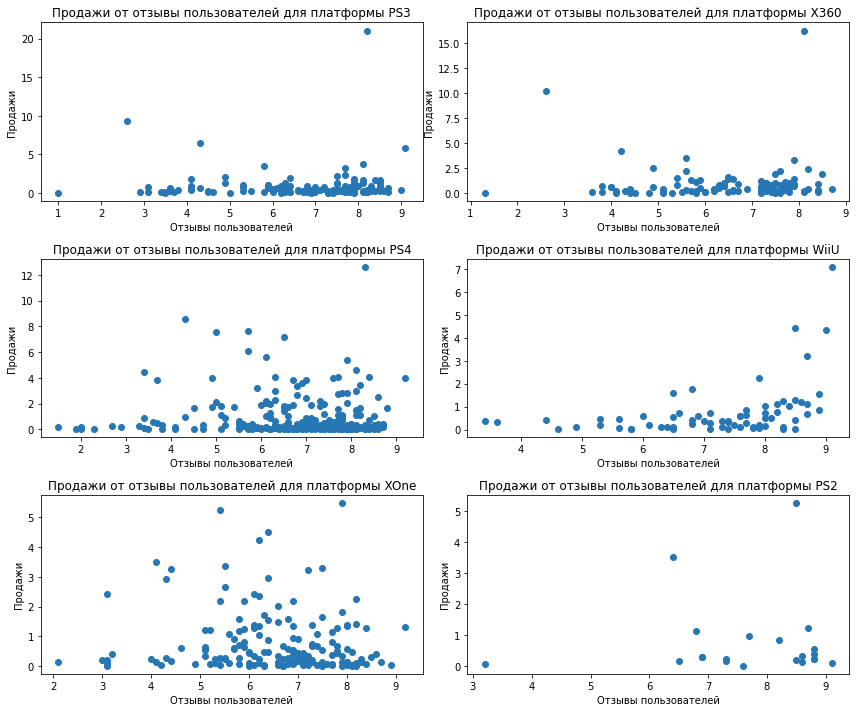

In [110]:
platforms = actual_df['platform'].unique()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

for i, platform in enumerate(platforms[:6]):
    platform_data = actual_df[actual_df['platform'] == platform]
    row = i // 2
    col = i % 2
    axes[row, col].scatter(platform_data['user_score'], platform_data['sum_sales'], color='#2777B4')
    axes[row, col].set_title(f'Продажи от отзывы пользователей для платформы {platform}')
    axes[row, col].set_xlabel('Отзывы пользователей')
    axes[row, col].set_ylabel('Продажи')

plt.tight_layout()
plt.show()

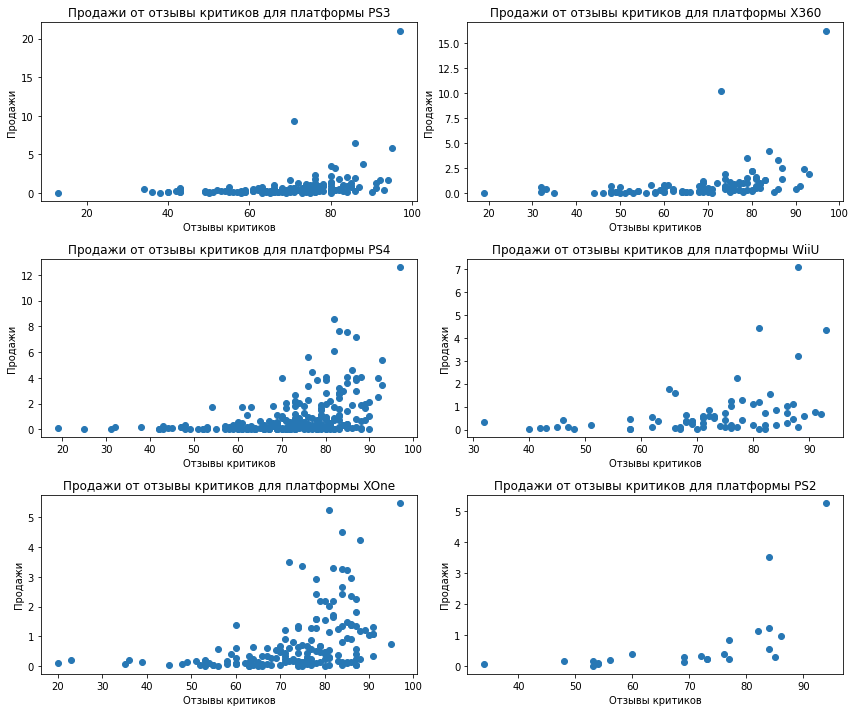

In [111]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

for i, platform in enumerate(platforms[:6]):
    platform_data = actual_df[actual_df['platform'] == platform]
    row = i // 2
    col = i % 2
    axes[row, col].scatter(platform_data['critic_score'], platform_data['sum_sales'], color='#2777B4')
    axes[row, col].set_title(f'Продажи от отзывы критиков для платформы {platform}')
    axes[row, col].set_xlabel('Отзывы критиков')
    axes[row, col].set_ylabel('Продажи')

plt.tight_layout()
plt.show()


#### Корреляция между отзывами и продажами по платформам ####

**Платформа PS4**

In [112]:
PS4_ratings = PS3.loc[:,['sum_sales', 'critic_score', 'user_score']]
PS4_ratings.head()
PS4_ratings.corr()

,sum_sales,critic_score,user_score
sum_sales,1.000000,0.273604,0.189575
critic_score,0.273604,1.000000,0.697425
user_score,0.189575,0.697425,1.000000


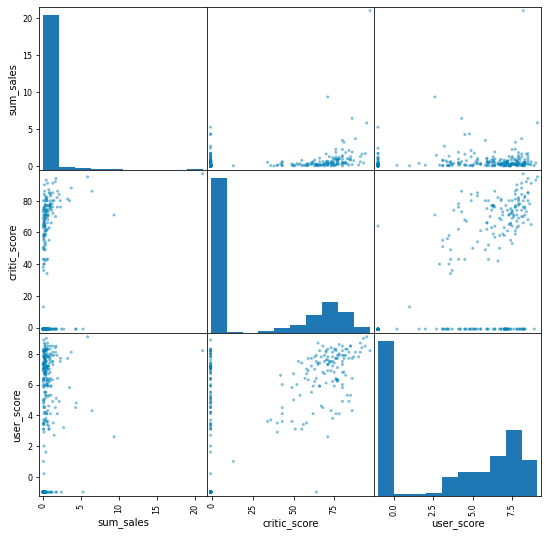

In [113]:
pd.plotting.scatter_matrix(PS4_ratings, figsize=(9, 9),color='#0081B8');

Вывод: PS4 - Прямая корреляция между продажами и рейтингом критиков. Чем выще критик оценивает игру, тем выше ее оценивают игроки

**Платформа PS3**

In [114]:
PS3_ratings = PS3.loc[:,['sum_sales', 'critic_score', 'user_score']]
PS3_ratings.head()
PS3_ratings.corr()

,sum_sales,critic_score,user_score
sum_sales,1.000000,0.273604,0.189575
critic_score,0.273604,1.000000,0.697425
user_score,0.189575,0.697425,1.000000


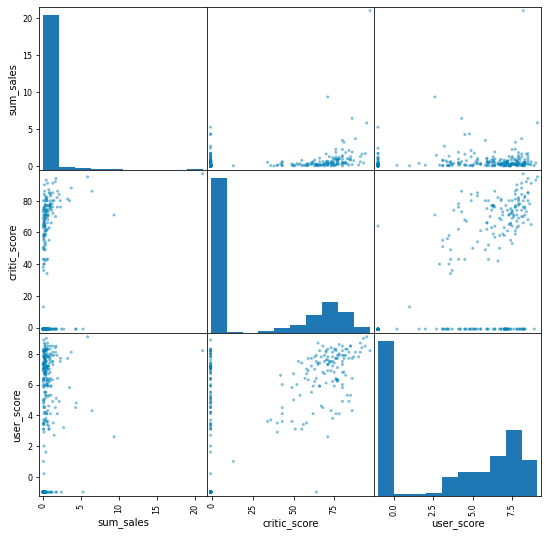

In [115]:
pd.plotting.scatter_matrix(PS3_ratings, figsize=(9, 9),color='#0081B8');

Вывод: PS3 - Корреляция между отзывами критиков и продажами ниже, чем у PS4. Оценка пользователя меньше зависит от оценки критиков, чем у PS4

**Платформа XOne**

In [116]:
XOne_ratings = XOne.loc[:,['sum_sales', 'critic_score', 'user_score']]
XOne_ratings.head()
XOne_ratings.corr()

,sum_sales,critic_score,user_score
sum_sales,1.000000,0.273782,0.085147
critic_score,0.273782,1.000000,0.783776
user_score,0.085147,0.783776,1.000000


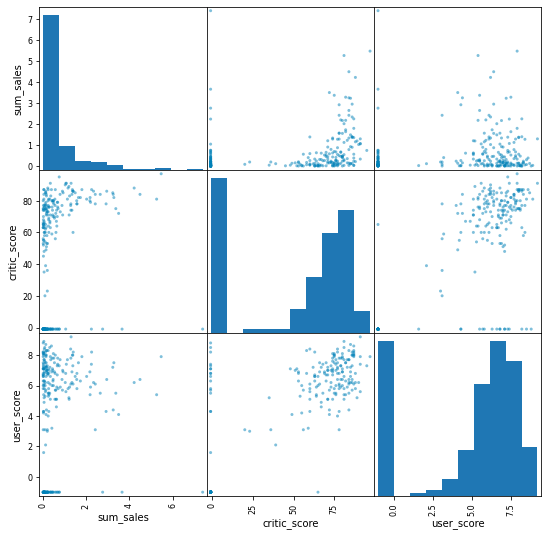

In [117]:
pd.plotting.scatter_matrix(XOne_ratings, figsize=(9, 9),color='#0081B8');

XOne - Корреляция между отзывами критиков и продажами слабая.  Есть корреляция между отзывами критиков и отзывами пользователей. Чем лучше отзывы критиков, тем выше оценка пользователей


**Платформа X360**

In [118]:
X360_ratings = X360.loc[:,['sum_sales', 'critic_score', 'user_score']]
X360_ratings.head()
X360_ratings.corr()

,sum_sales,critic_score,user_score
sum_sales,1.000000,0.230513,0.060562
critic_score,0.230513,1.000000,0.546089
user_score,0.060562,0.546089,1.000000


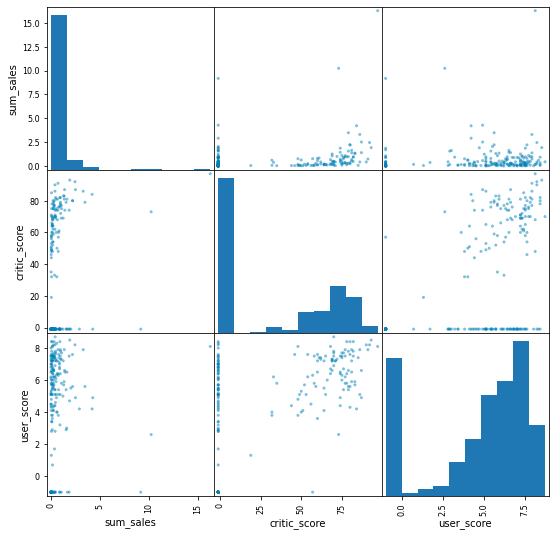

In [119]:
pd.plotting.scatter_matrix(X360_ratings, figsize=(9, 9),color='#0081B8');

X360 - Корреляция между отзывами критиков/пользователей и продажами слабая

**Платформа 3DS**

In [120]:
platform_3DS_ratings = platform_3DS.loc[:,['sum_sales', 'critic_score', 'user_score']]
platform_3DS_ratings.head()
platform_3DS_ratings.corr()

,sum_sales,critic_score,user_score
sum_sales,1.000000,0.061239,0.029234
critic_score,0.061239,1.000000,0.904836
user_score,0.029234,0.904836,1.000000


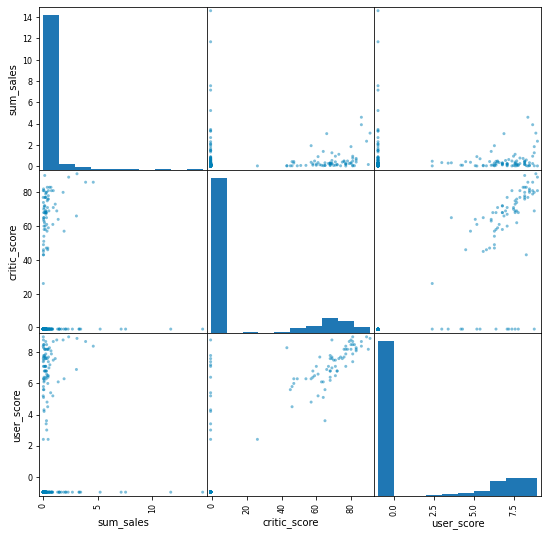

In [121]:
pd.plotting.scatter_matrix(platform_3DS_ratings, figsize=(9, 9),color='#0081B8');

3DS - Корреляция между отзывами критиков и продажами слабая.Есть корреляция между отзывами критиков и отзывами пользователей.

#### Вывод ####

У большинства платформ прослеживается корреляция между отзывами критиком и пользователей.   
PS4 - Прямая корреляция между продажами и рейтингом критиков. Чем выще критик оценивает игру, тем выше ее оценивают игроки.  
PS3 - Корреляция между отзывами критиков и продажами ниже, чем у PS4. Оценка пользователя меньше зависит от оценки критиков, чем у PS4.  
XOne - Корреляция между отзывами критиков и продажами слабая. Есть корреляция между отзывами критиков и отзывами пользователей. Чем лучше отзывы критиков, тем выше оценка пользователей.  
У платформ 3DS и X360 - Корреляция между отзывами критиков/пользователей и продажами слабая. Есть связь отзывов критиков с отзывами пользователей.


### Анализ продаж по жанрам за актуальный период ###

In [122]:
genre_games = pd.pivot_table(actual_df, index='genre', values='sum_sales', aggfunc='sum')
genre_games = genre_games.sort_values('sum_sales', ascending=False)
genre_games

,sum_sales
genre,
action,254.01
shooter,178.53
sports,132.59
role-playing,63.21
racing,38.28
platform,33.23
misc,29.03
fighting,18.81
simulation,13.05


In [123]:
genre_games['sum_sales'].describe()

count     12.000000
mean      65.423333
std       80.220684
min        2.940000
25%       12.955000
50%       31.130000
75%       80.555000
max      254.010000
Name: sum_sales, dtype: float64

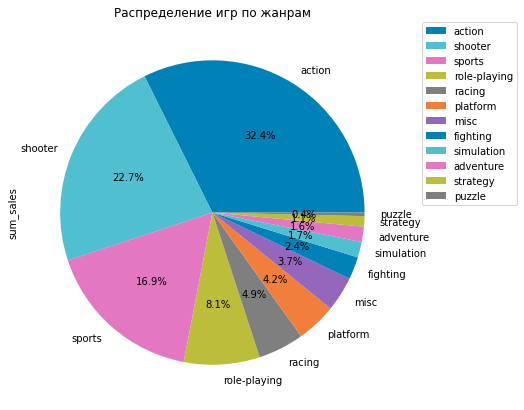

In [124]:
genre_games.plot(kind='pie',
                     subplots=True,
                     figsize=(14, 7),
                     autopct='%1.1f%%',
                     colors=['#0081B8',"#50BFCF",'#E377C1',"#BBBD3B",'#7F7F7F','#F17E3A',\
                             '#9467BD']);
plt.legend(bbox_to_anchor=( 1.05 , 1 ), loc='upper left', borderaxespad= 0 );
plt.title(f'Распределение игр по жанрам');


Медианное значение - 31.1  
Среднее значение - 65.4


Определим самые продаваемые жанры - жанры с продажами выше или приближенные к медианным.

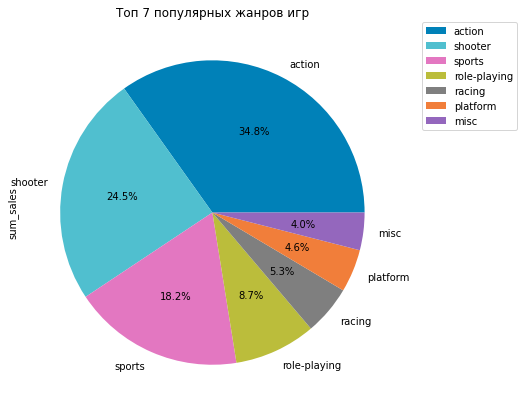

In [125]:
genre_games[:7].plot(kind='pie',
                     subplots=True,
                     figsize=(14, 7),
                     autopct='%1.1f%%',
                     colors=['#0081B8',"#50BFCF",'#E377C1',"#BBBD3B",'#7F7F7F','#F17E3A',\
                             '#9467BD']);
plt.legend(bbox_to_anchor=( 1.05 , 1 ), loc='upper left', borderaxespad= 0 );
plt.title(f'Топ 7 популярных жанров игр');

#### Вывод ####

Самые прибыльные жанры за период 2013-2016 гг - это Action(экшн),Shooter(шутер),Sports(спортивные игры) и Role-Playing(ролевые игры). Жанр Action самый популярный, 30% всех пользователей покупают игры этого жанра. ТОП-3 жанра, на которые нужно сделать ставки при планировании выхода на рынок - action,
shooter, sports. Более 70% игроков выбирают игры этих жанров.
Популярность этих жанров может быть связана с развитием платформ для совместной игры несколькоми игроками. Например, для игры в спортивные и ролевые игры обычно требуется несколько игроков.

Не пользуются популярностью за период 2013-2016 год игры-приключения (Adventure), симуляторы(Simulation), стратегии(Strategy) и головоломки (Puzzle).

###  Составьте портрет пользователя каждого региона ###

Определим для пользователя каждого региона (*NA, EU, JP*):

- Самые популярные платформы (топ-5).
- Самые популярные жанры (топ-5).
- Выясним, влияет ли рейтинг ESRB на продажи в отдельном регионе?

#### Популярные платформы по регионам ####

Создадим датафреймы с данными по регионам

In [126]:

na_actual = actual_df.query('na_sales > 0')
eu_actual = actual_df.query('eu_sales > 0')
jp_actual = actual_df.query('jp_sales > 0')


In [146]:
na_best_platform = pd.pivot_table(na_actual,
                                  index='platform',
                                  values='na_sales',
                                  aggfunc='sum').sort_values('na_sales', ascending=False)
eu_best_platform = pd.pivot_table(eu_actual,
                                  index='platform',
                                  values='eu_sales',
                                  aggfunc='sum').sort_values('eu_sales', ascending=False)
jp_best_platform = pd.pivot_table(jp_actual,
                                  index='platform',
                                  values='jp_sales',
                                  aggfunc='sum').sort_values('jp_sales', ascending=False)

In [147]:
def pie_genre(x):
    genre_sales = actual_df.query('year_of_release>1980')\
                           .groupby('genre')[x].sum()\
                           .sort_values(ascending=False)
    genre_sales_top = genre_sales[:5]
    genre_sales_top['other']=genre_sales.sum()-genre_sales[:5].sum()
    genre_sales_top.plot(kind='pie',autopct='%1.1f%%',\
                         colors=["#BBBD3B","#50BFCF",'#7F7F7F','#F17E3A','#9467BD','#E377C1'],\
                         figsize=(5,5));
    plt.legend(bbox_to_anchor=( 1.05 , 1 ), loc='upper left', borderaxespad= 0 )
    name = 'Северной Америке'
    if x == 'eu_sales':
        name = 'Европе' 
    if x == 'jp_sales':
        name = 'Японии'
    else:
        pass
    
    plt.title(f'Популярные жанры в {name}')
    return plt.show()  

In [148]:
def pie_platform(x):
    genre_sales = actual_df.query('year_of_release>1980')\
                           .groupby('platform')[x].sum()\
                           .sort_values(ascending=False)
    genre_sales_top = genre_sales[:5]
    genre_sales_top['other']=genre_sales.sum()-genre_sales[:5].sum()
    genre_sales_top.plot(kind='pie',autopct='%1.1f%%',\
                         colors=["#50BFCF","#8C564B",'#F17E3A','#BCBD3B','#2777B4','#E377C1'],\
                         figsize=(5,5));
    plt.legend(bbox_to_anchor=( 1.05 , 1 ), loc='upper left', borderaxespad= 0 )
    name = 'Северной Америке'
    if x == 'eu_sales':
        name = 'Европе' 
    if x == 'jp_sales':
        name = 'Японии'
    else:
        pass
    
    plt.title(f'Популярные платформы в {name}')
    return plt.show()  

 ##### Анализ продаж в Северной Америке #####

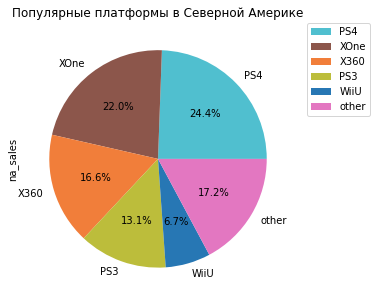

,na_sales
platform,
PS4,84.50
XOne,76.11
X360,57.40
PS3,45.33
WiiU,23.13


In [132]:
pie_platform('na_sales')

na_best_platform.head(5)

Топ популярных жанров в Америке: экшн, шутер, спортивные игры

 ##### Анализ продаж в Европе #####

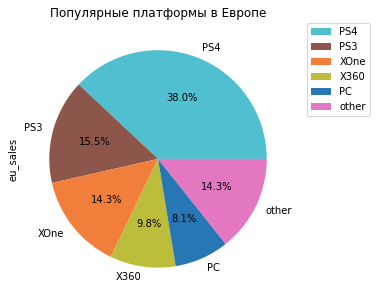

,eu_sales
platform,
PS4,112.44
PS3,45.97
XOne,42.30
X360,28.87
PC,23.97


In [134]:
pie_platform('eu_sales')

eu_best_platform.head(5)

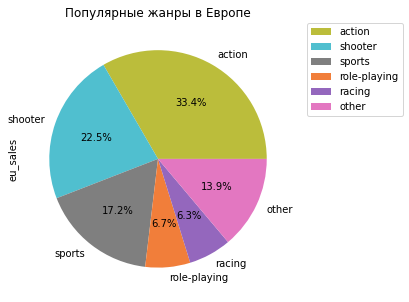

,eu_sales
genre,
action,98.72
shooter,66.63
sports,50.95
role-playing,19.75
racing,18.78


In [135]:
pie_genre('eu_sales')
eu_genre = pd.pivot_table(eu_actual,
                          index='genre',
                          values='eu_sales',
                          aggfunc='sum').sort_values('eu_sales', ascending=False)
eu_genre.head(5)

Топ популярных жанров в Европе: экшн, шутер, спортивные игры

 ##### Анализ продаж в  Японии #####

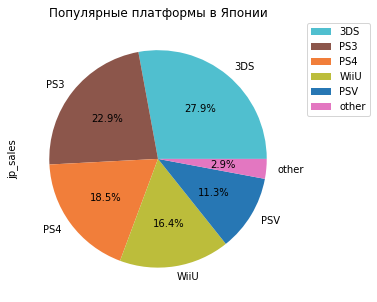

,jp_sales
platform,
3DS,14.22
PS3,11.69
PS4,9.43
WiiU,8.36
PSV,5.78


In [150]:
pie_platform('jp_sales')
jp_best_platform.head(5)

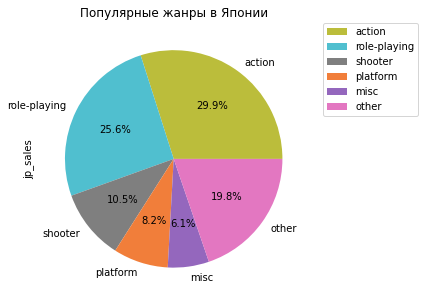

,jp_sales
genre,
action,15.25
role-playing,13.04
shooter,5.34
platform,4.16
misc,3.12


In [151]:
pie_genre('jp_sales')
jp_genre = pd.pivot_table(jp_actual,
                          index='genre',
                          values='jp_sales',
                          aggfunc='sum').sort_values('jp_sales', ascending=False)
jp_genre.head(5)

#### Влияние рейтинга ESRB ####

In [152]:
na_esrb_rating = pd.pivot_table(na_actual.query('rating != -1'),
                                index='rating',
                                values='na_sales',
                                aggfunc='sum').sort_values('na_sales', ascending=False)
na_esrb_rating

,na_sales
rating,
M,158.43
E,82.86
T,56.93
E10+,46.60


In [155]:
eu_esrb_rating = pd.pivot_table(eu_actual.query('rating != -1'),
                                index='rating',
                                values='eu_sales',
                                aggfunc='sum').sort_values('eu_sales', ascending=False)
eu_esrb_rating

,eu_sales
rating,
M,139.45
E,74.84
T,44.06
E10+,35.20
RP,0.04


В Америке и Европе популярны игры для пользователей старше 17 лет. Можно сделать вывод, что аудитория игр в Америке и Европе старше.


In [156]:
jp_esrb_rating = pd.pivot_table(jp_actual.query('rating != -1'),
                                index='rating',
                                values='jp_sales',
                                aggfunc='sum').sort_values('jp_sales', ascending=False)
jp_esrb_rating

,jp_sales
rating,
T,17.24
E,14.20
M,13.59
E10+,5.71


#### Вывод ####


В Северной Америке популярны платформы: PS4, XOne, X360, PS3 и 3DS  
В Европейском регионе популярны: PS4, PS3, XOne, X360 и 3DS  
В Японии популярны: 3DS, PS3, PSV, PS4 и WiiU  

Разница в популярных платформах по регионах может быть связана с популярностью различных производителей в данных регионах.
В Америке популярны платформы-конкуренты PS4 и XOne
В Японии большей популярностью пользуются платформа собственного производства Nintendo 3DS.  
В Европе список популярных платформ совпадает с самыми популярными по миру. Возможно список таков, так как в Европе нет крупного производителя игровых консолей.

Популярные жанры в Европе и Америке совпадают. Это экшн, шутер, спортивные игры
В Японии популярные жанры отличаются от других регионов. Это ролевые игры, экшн, Misc.
Различие может быть обусловлено в различиях в образе жизни и возрасте пользователей.

Рейтиг ESRB влияет на продажи в регионах.   
В Европе и Америке популярны игры для людей старше 17 лет и общие показатели продаж платформ выше.Можно сказать, больше взрослого населения пользуется игровыми платформами. В отличии от Японии.   
В Японии больше игр потребляет более младщая аудитория от 13 лет, поэтому показатели продаж ниже. 

**Портрет игроков по регионам**  

Игрок в Америке: возраст - старше 17 лет, любит играть на PS4 или XOne, выбирает жанры - экшн, шутер и спортивные игры  
Игрок в Европе: возраст - старше 17 лет, любит играть на PS4, выбирает жанры - экшн, шутер и спортивные игры  
Типичный игрок в Японии старше 13 лет, любит играть на 3DS или PSV, выбирает жанры - ролевые игры, экшн или Misc.

### Проверка гипотез ###

  
**Гипотеза 1. Средние пользовательские рейтинги платформ *Xbox One* и *PC* одинаковые**


  
Н0. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые  
Н1. Средние пользовательские рейтинги платформ Xbox One и PC различны  

In [157]:
new_df = df.query('critic_score!= -1 & user_score!= -1')

In [158]:
new_df['platform'].unique()

array(['Wii', 'DS', 'X360', 'PS3', 'PS2', '3DS', 'PS4', 'PS', 'XB', 'PC',
       'PSP', 'WiiU', 'GC', 'GBA', 'XOne', 'PSV', 'DC'], dtype=object)

In [159]:
alpha =0.05
XOne = new_df[(new_df['platform'] == 'XOne') & (new_df['user_score'] > 0)]['user_score']
PS4 = new_df[(new_df['platform'] == 'PC') & (new_df['user_score'] > 0)]['user_score']
results = st.ttest_ind(XOne, PS4)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
    print('Гипотеза 1 опровергнута: Средние пользовательские рейтинги платформ Xbox One и PC разные')
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    

p-значение: 0.00010749396991155507
Отвергаем нулевую гипотезу
Гипотеза 1 опровергнута: Средние пользовательские рейтинги платформ Xbox One и PC разные


**Гипотеза 2. Средние пользовательские рейтинги жанров *Action* и *Sports* разные.**


  
H0. средний пользовательский рейтинг жанров Action и Sports одинаковы  

H1. средний пользовательский рейтинг жанров Action и Sports различаются  

In [160]:
alpha = 0.05
action = new_df[(new_df['genre'] == 'action') &\
                   (new_df['user_score'] > 0)]['user_score']
sports = new_df[(new_df['genre'] == 'sports') &\
                   (new_df['user_score'] > 0)]['user_score']
results = st.ttest_ind(action, sports)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    print('Cредний пользовательский рейтинг жанров Action и Sports одинаковый')

p-значение: 0.8412827497852923
Не получилось отвергнуть нулевую гипотезу
Cредний пользовательский рейтинг жанров Action и Sports одинаковый


#### Вывод ####

Гипотеза 1 опровергнута. Результат - Средние пользовательские рейтинги платформ Xbox One и PC разные.  
Гипотеза 2 опровергнута. Результат - Средние пользовательские рейтинги жанров Action и Sports одинаковые.  


Нулевая гипотеза формулируется на основе утверждения об отсутствии различий. Н1 гипотеза - противоположна нулевой. Проверка гипотез происходила посредством pvalue-теста.
Взяла alpha = 0.05, так как такой показатель помещает всего 5% случаев в критическую область.

## Общий вывод ##  
  
  


В исследовании рассмотрены данные по продажам игр. 
Проведена подготовка и предобработка данных и исследовательский анализ датасета. 

Изучены сроки жизни платформ, определены самые прибыльные жанры по регионам, связь сежду отзывами и продажами. Сделан обзор портрета типичого игрока. 

**Средний срок жизни платформы** - 4 года, за это время платформа преодолевает пик продаж, когда повляется платформа следующего поколения. 
У большинства популярных платформ **прослеживается связь между отзывами критиком и пользователей и продажами**.

**Самые прибыльные жанры за актуальный период(2013-2016гг)** - это Action(экшн),Shooter(шутер), Sports(спортивные игры) и Role-Playing(ролевые игры).  
Жанры Action,Shooter, Sports выбирает более 70% всех пользователей.  
Популярность этих жанров может быть связана с развитием платформ для совместной игры несколькоми игроками. Так как срок "жизни" платформы 3-4 года, в 2017 году эти жанры также будут прибыльны и популярны.

Не пользуются популярностью за период 2013-2016 год игры-приключения (Adventure), симуляторы(Simulation), стратегии(Strategy) и головоломки (Puzzle). При планировании продаж 2017 года имеет смысл разрабатывать игры в иных жанрах.

**Возраст игроков** Европы и Америки значительно выше, чем в Японии. В этих странах в компьтерные игры вовлечены большее количество людей, поэтому продажи платформ выше.  
В Северной Америке популярны платформы: PS4, XOne, X360, PS3 и 3DS
В Европейском регионе популярны: PS4, PS3, XOne, X360 и 3DS
В Японии популярны: 3DS, PS3, PSV, PS4 и WiiU

Разница в популярных платформах по регионах может быть связана с популярностью различных производителей в данных регионах. В Америке популярны платформы-конкуренты PS4 и XOne В Японии большей популярностью пользуются платформа собственного производства Nintendo 3DS.
В Европе список популярных платформ совпадает с самыми популярными по миру. Возможно список таков, так как в Европе нет крупного производителя игровых консолей.

Популярные жанры в Европе и Америке совпадают. Это экшн, шутер, спортивные игры В Японии популярные жанры отличаются от других регионов. Это ролевые игры, экшн, Misc. Различие может быть обусловлено в различиях в образе жизни и возрасте пользователей.

**Рейтиг ESRB влияет на продажи в регионах.**
В Европе и Америке популярны игры для людей старше 17 лет и общие показатели продаж платформ выше.Можно сказать, больше взрослого населения пользуется игровыми платформами. В отличии от Японии.
В Японии больше игр потребляет более младщая аудитория от 13 лет, поэтому показатели продаж ниже.

**В результате исследования проверены следущие гипотезы:**   
1. Гипотеза 1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые  
2. Гипотеза 2. Средние пользовательские рейтинги жанров Action и Sports разные.  
Результат: гипотеза 1 опровергнута, гипотеза 2 опровергнута.


**Рекомендации по планированию рекламных кампаний:**
1. При выпуске новых игр ориентироваться на данные о самых продаваемых жанрах по регионам
2. Учитывать что средний срок жизни платформы 4 года
3. Для некоторых платформ есть связь между отзывами критиков и ростом продаж и влияние отзывов критиков на отзывы игроков. При планировании рекламы выгодно получить хорошие отзывы критиков.
